# Kompletna analiza WESAD z SMOTE - od parsowania do wyników

## Cel
Kompletna analiza danych WESAD. Zak z prawidłową procedurą:
1. ✅ **Parsowanie** surowych danych (CSV + PKL)
2. ✅ **Synchronizacja** wrist i chest (resampling do 32 Hz, wyrównanie czasowe)
3. ✅ **Segmentacja** na okna czasowe (60 sekund)
4. ✅ **Feature engineering** (statystyki per okno)
5. ✅ Analiza niezbalansowania klas
6. ✅ **SMOTE** (po segmentacji!)
7. ✅ Cross-subject validation
8. ✅ Trenowanie modeli (RF, SVM, XGBoost)
9. ✅ Analiza wyników

## Kluczowe zasady
- ⚠️ **SMOTE TYLKO PO SEGMENTACJI** (nie na surowych sygnałach)
- ⚠️ **Cross-subject validation** (nie losowy podział)
- ⚠️ **Macro F1-score** zamiast accuracy
- ⚠️ **Synchronizacja przed segmentacją** - wszystkie sygnały muszą być na tej samej osi czasu i częstotliwości


In [24]:
# ============================================================================
# KROK 0: IMPORT I KONFIGURACJA
# ============================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from functools import lru_cache
from scipy.signal import resample
import warnings
warnings.filterwarnings('ignore')

# Ścieżki
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")

# Parametry
WINDOW_SIZE_SECONDS = 60  # Rozmiar okna w sekundach
TARGET_FS = 32.0
TARGET_CHEST_FS = 32.0
MAX_DURATION = pd.Timedelta(minutes=40)

# Uczestnicy
DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

# Schematy sensorów
SENSOR_SCHEMAS = {
    "ACC": ["acc_x", "acc_y", "acc_z"],
    "EDA": ["eda"],
    "BVP": ["bvp"],
    "TEMP": ["temp"],
    "HR": ["hr"],
}

CHEST_COLUMNS = {
    "ACC": ["chest_acc_x", "chest_acc_y", "chest_acc_z"],
    "ECG": ["chest_ecg"],
    "EMG": ["chest_emg"],
    "EDA": ["chest_eda"],
    "Temp": ["chest_temp"],
    "Resp": ["chest_resp"],
}
CHEST_FS = {key: 700.0 for key in CHEST_COLUMNS}

# Mapowanie faz do klas
PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
}

print("=" * 80)
print("KROK 0: IMPORT I KONFIGURACJA")
print("=" * 80)
print(f"✓ Konfiguracja załadowana")
print(f"✓ Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund")
print(f"✓ Docelowa częstotliwość próbkowania: {TARGET_FS} Hz")


KROK 0: IMPORT I KONFIGURACJA
✓ Konfiguracja załadowana
✓ Rozmiar okna: 60 sekund
✓ Docelowa częstotliwość próbkowania: 32.0 Hz


## KROK 1: Parsowanie i synchronizacja - INFORMACJA

### ⚠️ **WAŻNE:** Parsowanie i synchronizacja powinny być wykonane PRZED tym notebookiem!

**Gdzie znajdziesz pełne parsowanie i synchronizację:**
- Notebook: `01_complete_analysis.ipynb` 
- Sekcje: 1-5 (Parsowanie, Synchronizacja, Segmentacja)

**Co jest wykonywane w `01_complete_analysis.ipynb`:**
1. **Parsowanie** surowych plików:
   - CSV (wrist) - wczytywanie z nagłówkami (timestamp, fs)
   - PKL (chest) - wczytywanie z encoding='latin1'
   
2. **Synchronizacja** (KLUCZOWE!):
   - Resampling wszystkich sygnałów do **32 Hz**
   - Wyrównanie czasowe - wspólna oś czasu (timestamp)
   - Merge wrist i chest na wspólnej osi czasu
   
3. **Segmentacja**:
   - Podział na okna czasowe (60 sekund)
   - Feature engineering (statystyki per okno)
   - Zapis do CSV/Parquet

**Ten notebook (`03_complete_analysis_with_smote.ipynb`)** zakłada, że:
- ✅ Dane są już sparserowane
- ✅ Dane są zsynchronizowane (wszystkie sygnały do 32 Hz, wspólna oś czasu)
- ✅ Dane są zsegmentowane (okna czasowe z cechami statystycznymi)

**Jeśli nie masz jeszcze przetworzonych danych:**
1. Uruchom `01_complete_analysis.ipynb` (sekcje 1-5)
2. Zapisz dane do CSV/Parquet
3. Wróć tutaj i uruchom ten notebook


## KROK 1B: WERYFIKACJA SYNCHRONIZACJI DANYCH

**WAŻNE:** Ten notebook wymaga danych, które zostały już:
1. **Sparserowane** z surowych plików (CSV + PKL)
2. **Zsynchronizowane** - wszystkie sygnały zsynchronizowane do 32 Hz i wspólnej osi czasu
3. **Zsegmentowane** - podzielone na okna czasowe (60 sekund)

Jeśli nie masz jeszcze przetworzonych danych, uruchom notebook `01_complete_analysis.ipynb` sekcje 1-5 (parsowanie, synchronizacja, segmentacja).


KROK 2: WCZYTYWANIE DANYCH PO SEGMENTACJI

✓ Wczytano z Parquet: 142 próbek

WERYFIKACJA: SYNCHRONIZACJA I STRUKTURA DANYCH

✓ Struktura danych:
  Liczba próbek: 142
  Liczba kolumn: 19

✓ Weryfikacja synchronizacji:
  Kolumny wrist: 9 (np. EDA, HR, TEMP, ACC, BVP)
  Kolumny chest: 5 (np. chest_ecg, chest_eda, chest_resp)
  Cechy statystyczne: 12 (średnie, odchylenia, RMSSD, itp.)
  ✓ Wymagane kolumny: timestamp, subject, label - OK
  ✓ Uczestnicy w danych: 6 (S2, S3, S4, S5, S6, S7)
  ✓ Kolumna timestamp: OK (sygnały są zsynchronizowane czasowo)

💡 WNIOSEK:
  ✓ Dane są PO SEGMENTACJI (mają statystyki per okno czasowe)
  ✓ Dane zawierają zarówno wrist jak i chest - prawdopodobnie zsynchronizowane
  → Można przejść do analizy niezbalansowania i SMOTE

ANALIZA ROZKŁADU KLAS (PO SEGMENTACJI)

📊 ROZKŁAD KLAS:
--------------------------------------------------------------------------------
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)
  amusement   :   18 próbek 

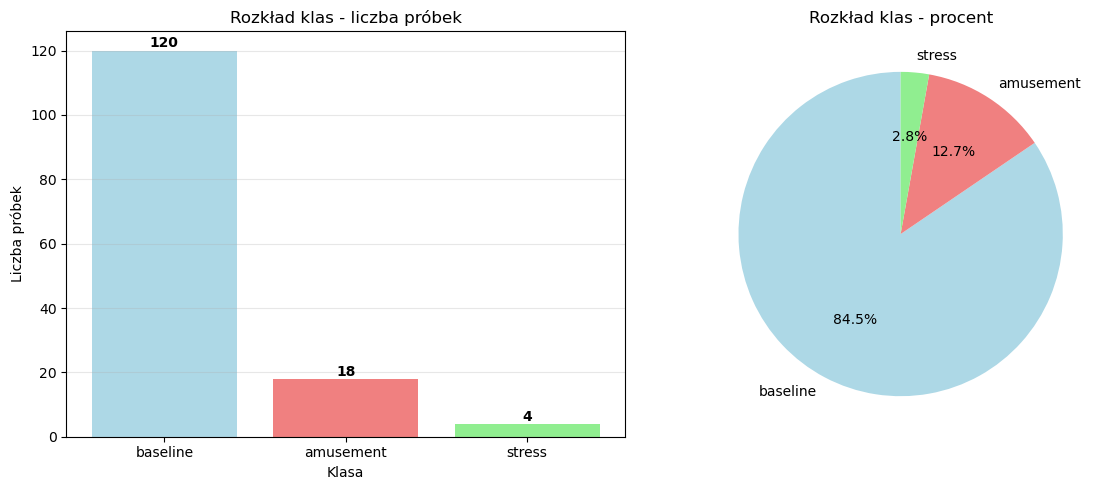


✓ DANE WCZYTANE I PRZEANALIZOWANE


In [25]:
# ============================================================================
# KROK 2: WCZYTYWANIE PRZETWORZONYCH DANYCH (PO SEGMENTACJI)
# ============================================================================

print("=" * 80)
print("KROK 2: WCZYTYWANIE DANYCH PO SEGMENTACJI")
print("=" * 80)

# Sprawdzamy czy mamy przetworzone dane
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed" / "multi_subject_wrist_chest.csv"
PARQUET_PATH = PROJECT_ROOT / "data" / "processed" / "multi_subject_wrist_chest.parquet"

multi_dataset_segmented = None

# Próbujemy wczytać z parquet (szybsze)
if PARQUET_PATH.exists():
    try:
        import pyarrow
        multi_dataset_segmented = pd.read_parquet(PARQUET_PATH)
        print(f"\n✓ Wczytano z Parquet: {len(multi_dataset_segmented)} próbek")
    except ImportError:
        print("⚠ Nie można wczytać Parquet - próbuję CSV...")
        if PROCESSED_DATA_PATH.exists():
            multi_dataset_segmented = pd.read_csv(PROCESSED_DATA_PATH)
            print(f"✓ Wczytano z CSV: {len(multi_dataset_segmented)} próbek")
elif PROCESSED_DATA_PATH.exists():
    multi_dataset_segmented = pd.read_csv(PROCESSED_DATA_PATH)
    print(f"\n✓ Wczytano z CSV: {len(multi_dataset_segmented)} próbek")
else:
    print(f"\n❌ BŁĄD: Nie znaleziono przetworzonych danych!")
    print(f"   Ścieżki sprawdzone:")
    print(f"     - {PARQUET_PATH}")
    print(f"     - {PROCESSED_DATA_PATH}")
    print(f"\n   💡 Uruchom najpierw notebook '01_complete_analysis.ipynb'")
    print(f"      aby przetworzyć dane i zapisać je do CSV/Parquet")

if multi_dataset_segmented is not None:
    # WERYFIKACJA SYNCHRONIZACJI I STRUKTURY DANYCH
    print(f"\n{'='*80}")
    print("WERYFIKACJA: SYNCHRONIZACJA I STRUKTURA DANYCH")
    print(f"{'='*80}")
    
    # Sprawdzenie struktury danych
    print(f"\n✓ Struktura danych:")
    print(f"  Liczba próbek: {len(multi_dataset_segmented)}")
    print(f"  Liczba kolumn: {len(multi_dataset_segmented.columns)}")
    
    # Sprawdzenie czy są kolumny z wrist i chest
    wrist_cols = [col for col in multi_dataset_segmented.columns if any(x in col.lower() for x in ['eda', 'hr', 'temp', 'acc', 'bvp']) and 'chest' not in col.lower()]
    chest_cols = [col for col in multi_dataset_segmented.columns if 'chest' in col.lower()]
    
    print(f"\n✓ Weryfikacja synchronizacji:")
    print(f"  Kolumny wrist: {len(wrist_cols)} (np. EDA, HR, TEMP, ACC, BVP)")
    print(f"  Kolumny chest: {len(chest_cols)} (np. chest_ecg, chest_eda, chest_resp)")
    
    # Sprawdzenie czy dane są po segmentacji (powinny mieć statystyki per okno)
    stats_features = [col for col in multi_dataset_segmented.columns if any(x in col for x in ['_mean', '_std', '_min', '_max', '_rmssd', '_rate'])]
    print(f"  Cechy statystyczne: {len(stats_features)} (średnie, odchylenia, RMSSD, itp.)")
    
    # Sprawdzenie czy są wymagane kolumny
    required_cols = ['timestamp', 'subject', 'label']
    missing_cols = [col for col in required_cols if col not in multi_dataset_segmented.columns]
    
    if missing_cols:
        print(f"\n  ⚠️ BRAKUJĄCE KOLUMNY: {missing_cols}")
    else:
        print(f"  ✓ Wymagane kolumny: timestamp, subject, label - OK")
    
    # Sprawdzenie czy są dane z różnych uczestników
    if 'subject' in multi_dataset_segmented.columns:
        unique_subjects = multi_dataset_segmented['subject'].unique()
        print(f"  ✓ Uczestnicy w danych: {len(unique_subjects)} ({', '.join(sorted(unique_subjects))})")
    
    # Sprawdzenie czy dane mają timestamp (wskazuje na synchronizację czasową)
    if 'timestamp' in multi_dataset_segmented.columns:
        print(f"  ✓ Kolumna timestamp: OK (sygnały są zsynchronizowane czasowo)")
    
    print(f"\n💡 WNIOSEK:")
    if len(stats_features) > 0:
        print(f"  ✓ Dane są PO SEGMENTACJI (mają statystyki per okno czasowe)")
        print(f"  ✓ Dane zawierają zarówno wrist jak i chest - prawdopodobnie zsynchronizowane")
        print(f"  → Można przejść do analizy niezbalansowania i SMOTE")
    else:
        print(f"  ⚠️ Dane mogą nie być po segmentacji - sprawdź czy masz statystyki per okno")
    
    print(f"\n{'='*80}")
    print("ANALIZA ROZKŁADU KLAS (PO SEGMENTACJI)")
    print(f"{'='*80}")
    
    # Rozkład klas
    class_dist = multi_dataset_segmented['label'].value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS:")
    print("-" * 80)
    for label in ['baseline', 'stress', 'amusement']:
        count = class_dist.get(label, 0)
        pct = (count / len(multi_dataset_segmented) * 100) if len(multi_dataset_segmented) > 0 else 0
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    total = len(multi_dataset_segmented)
    print(f"\n  Total: {total} próbek")
    
    # Analiza nierównowagi
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    print(f"\n⚠️ ANALIZA NIERÓWNOWAGI:")
    if stress_count > 0:
        imbalance_stress = baseline_count / stress_count
        print(f"  baseline vs stress: {imbalance_stress:.1f}x")
    if amusement_count > 0:
        imbalance_amusement = baseline_count / amusement_count
        print(f"  baseline vs amusement: {imbalance_amusement:.1f}x")
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Barplot
    axes[0].bar(class_dist.index, class_dist.values, 
               color=['lightblue', 'lightcoral', 'lightgreen'][:len(class_dist)])
    axes[0].set_xlabel('Klasa')
    axes[0].set_ylabel('Liczba próbek')
    axes[0].set_title('Rozkład klas - liczba próbek')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości
    for i, (label, count) in enumerate(class_dist.items()):
        axes[0].text(i, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
               colors=['lightblue', 'lightcoral', 'lightgreen'][:len(class_dist)], startangle=90)
    axes[1].set_title('Rozkład klas - procent')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print("✓ DANE WCZYTANE I PRZEANALIZOWANE")
    print(f"{'='*80}")


KROK 3: PRZYGOTOWANIE DANYCH, SMOTE I ML

1. PRZYGOTOWANIE DANYCH DO ML

✓ Filtrowanie danych:
  Przed: 142 próbek
  Po (bez stress): 138 próbek
  Liczba cech: 15
  Liczba próbek: 138
  Klasy: ['amusement' 'baseline']

2. ROZKŁAD KLAS PRZED BALANSOWANIEM

📊 ROZKŁAD KLAS PRZED SMOTE:
--------------------------------------------------------------------------------
  baseline    :  120 próbek ( 87.0%)
  amusement   :   18 próbek ( 13.0%)

  Nierównowaga: 6.67x

3. SPRAWDZENIE DOSTĘPNOŚCI SMOTE

✓ SMOTE dostępny - użyjemy do balansowania

4. CROSS-SUBJECT VALIDATION I TRENOWANIE MODELI

  Liczba uczestników: 6
  Używamy 5-fold cross-validation
  Uczestnicy: S2, S3, S4, S5, S6, S7

  ✓ XGBoost dostępny (objective: binary:logistic)

TRENOWANIE: RandomForest

  Fold 1 - rozkład klas w train (przed SMOTE):
    baseline    :   97 próbek
    amusement   :   12 próbek
  Fold 1 - po SMOTE:
    baseline    :   97 próbek
    amusement   :   97 próbek

  📊 ŚREDNIE WYNIKI (RandomForest):
     Macro F1

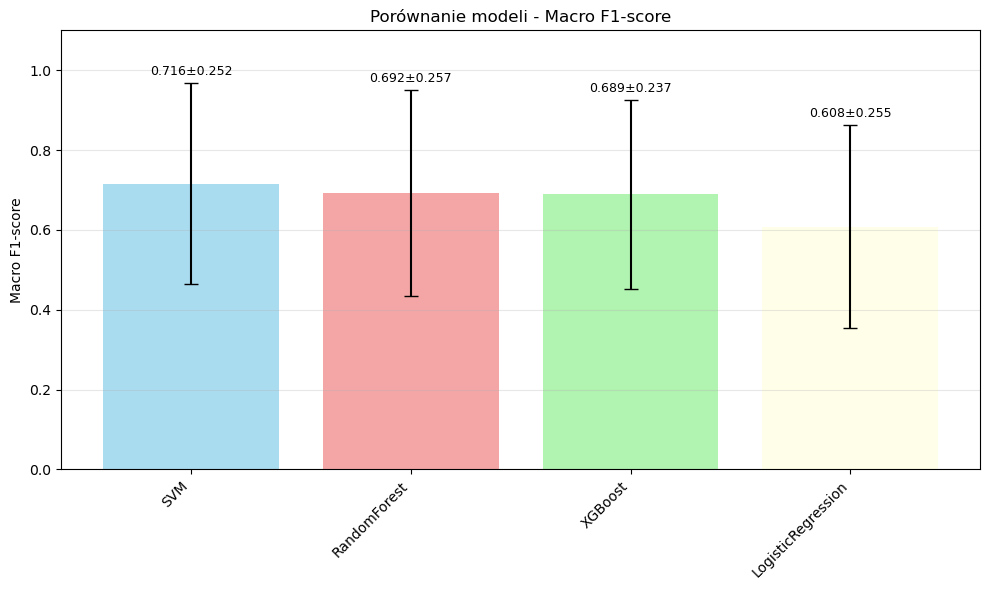


🎯 NAJLEPSZY MODEL: SVM
   Macro F1-score: 0.716

✓ KROK 3 ZAKOŃCZONY


In [26]:
# ============================================================================
# KROK 3: PRZYGOTOWANIE DANYCH, SMOTE I TRENOWANIE MODELI
# ============================================================================

print("=" * 80)
print("KROK 3: PRZYGOTOWANIE DANYCH, SMOTE I ML")
print("=" * 80)

# Sprawdzenie czy mamy dane
if 'multi_dataset_segmented' not in globals() or multi_dataset_segmented is None:
    print("\n⚠ Najpierw uruchom KROK 2, aby wczytać dane")
else:
    # PRZYGOTOWANIE DANYCH
    print(f"\n{'='*80}")
    print("1. PRZYGOTOWANIE DANYCH DO ML")
    print(f"{'='*80}")
    
    # Filtrujemy tylko baseline i amusement (stress ma za mało próbek)
    data_ml = multi_dataset_segmented[multi_dataset_segmented['label'].isin(['baseline', 'amusement'])].copy()
    
    print(f"\n✓ Filtrowanie danych:")
    print(f"  Przed: {len(multi_dataset_segmented)} próbek")
    print(f"  Po (bez stress): {len(data_ml)} próbek")
    
    # Feature columns
    feature_columns = [col for col in data_ml.columns 
                      if col not in {"timestamp", "phase", "label", "subject"}]
    
    X_segmented = data_ml[feature_columns].fillna(0.0).values
    y_segmented = data_ml["label"].values
    groups_segmented = data_ml["subject"].values
    
    print(f"  Liczba cech: {len(feature_columns)}")
    print(f"  Liczba próbek: {len(X_segmented)}")
    
    # Label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_segmented_encoded = label_encoder.fit_transform(y_segmented)
    
    print(f"  Klasy: {label_encoder.classes_}")
    
    # ROZKŁAD KLAS PRZED BALANSOWANIEM
    print(f"\n{'='*80}")
    print("2. ROZKŁAD KLAS PRZED BALANSOWANIEM")
    print(f"{'='*80}")
    
    class_dist_before = pd.Series(y_segmented).value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS PRZED SMOTE:")
    print("-" * 80)
    for label in class_dist_before.index:
        count = class_dist_before[label]
        pct = (count / len(y_segmented) * 100)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    imbalance_before = class_dist_before.max() / class_dist_before.min()
    print(f"\n  Nierównowaga: {imbalance_before:.2f}x")
    
    # SPRAWDZENIE CZY SMOTE JEST DOSTĘPNY
    print(f"\n{'='*80}")
    print("3. SPRAWDZENIE DOSTĘPNOŚCI SMOTE")
    print(f"{'='*80}")
    
    try:
        from imblearn.over_sampling import SMOTE
        SMOTE_AVAILABLE = True
        print(f"\n✓ SMOTE dostępny - użyjemy do balansowania")
    except ImportError:
        SMOTE_AVAILABLE = False
        print(f"\n⚠ SMOTE niedostępny!")
        print(f"   Zainstaluj: pip install imbalanced-learn")
        print(f"   Użyjemy tylko class_weight w modelach")
    
    # CROSS-SUBJECT VALIDATION I TRENOWANIE
    print(f"\n{'='*80}")
    print("4. CROSS-SUBJECT VALIDATION I TRENOWANIE MODELI")
    print(f"{'='*80}")
    
    from sklearn.model_selection import GroupKFold
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report, f1_score, confusion_matrix
    
    # Liczba uczestników
    unique_subjects = np.unique(groups_segmented)
    n_splits = min(5, len(unique_subjects))
    
    print(f"\n  Liczba uczestników: {len(unique_subjects)}")
    print(f"  Używamy {n_splits}-fold cross-validation")
    print(f"  Uczestnicy: {', '.join(sorted(unique_subjects))}")
    
    gkf = GroupKFold(n_splits=n_splits)
    
    # Modele do przetestowania
    models_to_test = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            random_state=42,
            class_weight='balanced'
        ),
        'SVM': SVC(
            kernel='rbf',
            probability=True,
            random_state=42,
            class_weight='balanced'
        ),
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        )
    }
    
    # Próbujemy dodać XGBoost
    try:
        from xgboost import XGBClassifier
        
        n_classes = len(label_encoder.classes_)
        if n_classes == 2:
            xgb_objective = 'binary:logistic'
        else:
            xgb_objective = 'multi:softprob'
        
        baseline_count = class_dist_before.get('baseline', 1)
        amusement_count = class_dist_before.get('amusement', 1)
        
        models_to_test['XGBoost'] = XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            objective=xgb_objective,
            eval_metric='logloss' if n_classes == 2 else 'mlogloss',
            scale_pos_weight=baseline_count / amusement_count if n_classes == 2 else None
        )
        print(f"\n  ✓ XGBoost dostępny (objective: {xgb_objective})")
    except ImportError:
        print(f"\n  ⚠ XGBoost niedostępny - pomijam")
    
    # Wyniki dla wszystkich modeli
    all_results = {}
    
    # Testowanie każdego modelu
    for model_name, model in models_to_test.items():
        print(f"\n{'='*80}")
        print(f"TRENOWANIE: {model_name}")
        print(f"{'='*80}")
        
        fold_results = []
        all_y_test = []
        all_y_pred = []
        
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_segmented, y_segmented_encoded, groups_segmented), start=1):
            X_train, X_test = X_segmented[train_idx], X_segmented[test_idx]
            y_train, y_test = y_segmented_encoded[train_idx], y_segmented_encoded[test_idx]
            
            # Sprawdzenie rozkładu w train (fold 1)
            if fold == 1:
                train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
                print(f"\n  Fold {fold} - rozkład klas w train (przed SMOTE):")
                for label in train_dist.index:
                    print(f"    {label:12s}: {train_dist[label]:4d} próbek")
            
            # SMOTE TYLKO NA ZBIORZE TRENINGOWYM!
            X_train_bal = X_train
            y_train_bal = y_train
            
            if SMOTE_AVAILABLE:
                try:
                    # Obliczamy k_neighbors - musi być mniejsze niż liczba próbek mniejszościowej klasy
                    min_class_count = min(pd.Series(y_train).value_counts().values)
                    k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
                    
                    if k_neighbors > 0:
                        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
                        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
                        
                        if fold == 1:
                            train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
                            print(f"  Fold {fold} - po SMOTE:")
                            for label in train_dist_after.index:
                                print(f"    {label:12s}: {train_dist_after[label]:4d} próbek")
                except Exception as e:
                    if fold == 1:
                        print(f"  ⚠️ SMOTE nie powiódł się dla fold {fold}: {e}")
                    X_train_bal, y_train_bal = X_train, y_train
            
            # Pipeline z scaling
            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("model", model)
            ])
            
            # Trenowanie
            clf.fit(X_train_bal, y_train_bal)
            y_pred = clf.predict(X_test)
            
            # Ewaluacja
            f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
            f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            fold_results.append({
                'fold': fold,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            })
            
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
        
        # Podsumowanie dla modelu
        avg_f1_macro = np.mean([r['f1_macro'] for r in fold_results])
        std_f1_macro = np.std([r['f1_macro'] for r in fold_results])
        
        print(f"\n  📊 ŚREDNIE WYNIKI ({model_name}):")
        print(f"     Macro F1-score: {avg_f1_macro:.3f} ± {std_f1_macro:.3f}")
        
        # Classification report (ze wszystkich foldów)
        print(f"\n  📋 Classification Report (wszystkie foldy):")
        report = classification_report(
            all_y_test, all_y_pred,
            target_names=label_encoder.classes_,
            output_dict=True,
            zero_division=0
        )
        
        print(f"     {'Klasa':<12} {'Precision':<12} {'Recall':<12} {'F1-score':<12}")
        print("     " + "-" * 48)
        for cls in label_encoder.classes_:
            if cls in report:
                prec = report[cls]['precision']
                rec = report[cls]['recall']
                f1 = report[cls]['f1-score']
                print(f"     {cls:<12} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")
        
        all_results[model_name] = {
            'avg_f1_macro': avg_f1_macro,
            'std_f1_macro': std_f1_macro,
            'fold_results': fold_results,
            'y_test': all_y_test,
            'y_pred': all_y_pred,
            'report': report
        }
    
    # PORÓWNANIE MODELI
    print(f"\n{'='*80}")
    print("5. PODSUMOWANIE - PORÓWNANIE MODELI")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame({
        'Model': list(all_results.keys()),
        'Macro F1': [all_results[m]['avg_f1_macro'] for m in all_results.keys()],
        'Std': [all_results[m]['std_f1_macro'] for m in all_results.keys()]
    })
    comparison_df = comparison_df.sort_values('Macro F1', ascending=False)
    
    print("\n", comparison_df.to_string(index=False))
    
    # Wykres porównania
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = comparison_df['Model'].values
    f1_scores = comparison_df['Macro F1'].values
    stds = comparison_df['Std'].values
    
    bars = ax.bar(models, f1_scores, yerr=stds, alpha=0.7, capsize=5, 
                  color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'][:len(models)])
    ax.set_ylabel('Macro F1-score')
    ax.set_title('Porównanie modeli - Macro F1-score')
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości na słupkach
    for i, (bar, f1, std) in enumerate(zip(bars, f1_scores, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
               f'{f1:.3f}±{std:.3f}', ha='center', fontsize=9)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Najlepszy model
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\n🎯 NAJLEPSZY MODEL: {best_model_name}")
    print(f"   Macro F1-score: {all_results[best_model_name]['avg_f1_macro']:.3f}")
    
    print(f"\n{'='*80}")
    print("✓ KROK 3 ZAKOŃCZONY")
    print(f"{'='*80}")


## KROK 3B: SZCZEGÓŁOWA ANALIZA ROZKŁADU KLAS - PRZED I PO SMOTE

Poniżej szczegółowa analiza rozkładu klas pokazująca wpływ SMOTE na balansowanie danych.


SZCZEGÓŁOWA ANALIZA ROZKŁADU KLAS - PRZED I PO SMOTE

1. ANALIZA PO SEGMENTACJI - PRZED FILTRACJĄ

📊 ROZKŁAD KLAS PO SEGMENTACJI (wszystkie klasy):
--------------------------------------------------------------------------------
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)
  amusement   :   18 próbek ( 12.7%)

  Total: 142 próbek

2. ANALIZA PRZED SMOTE (PO FILTRACJI - baseline + amusement)

📊 ROZKŁAD KLAS PRZED SMOTE:
--------------------------------------------------------------------------------
  amusement   :   18 próbek ( 13.0%)
  baseline    :  120 próbek ( 87.0%)

  Total: 138 próbek
  Nierównowaga: 6.67x


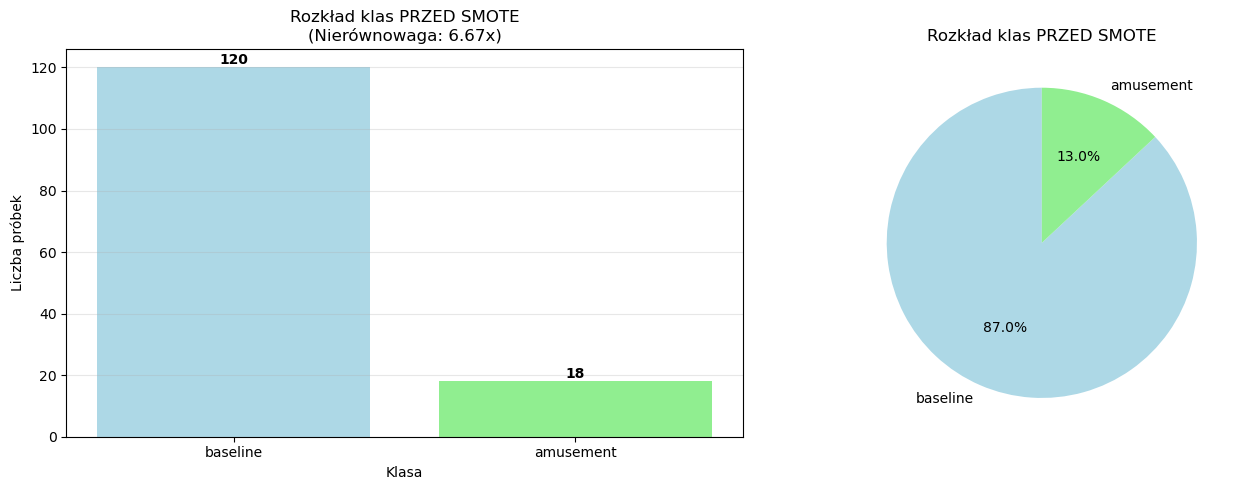


3. WYKONANIE SMOTE (dla wizualizacji rozkładu po SMOTE)

  Stosuję SMOTE z k_neighbors=3

📊 ROZKŁAD KLAS PO SMOTE:
--------------------------------------------------------------------------------
  amusement   :  120 próbek ( 50.0%)
  baseline    :  120 próbek ( 50.0%)

  Total: 240 próbek
  Nierównowaga: 1.00x

4. PORÓWNANIE PRZED I PO SMOTE

     Klasa  Przed SMOTE  Po SMOTE  Różnica  Wzrost (%)
amusement           18       120      102       566.7
 baseline          120       120        0         0.0


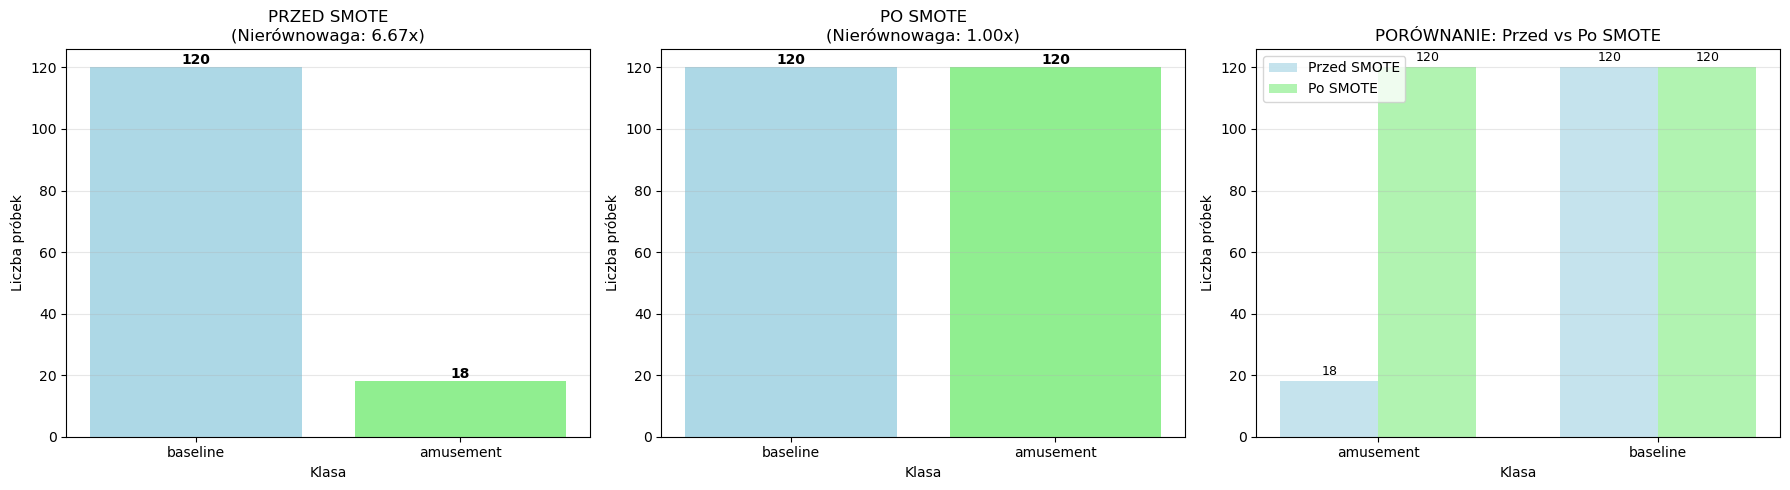


5. PODSUMOWANIE WPŁYWU SMOTE

  ✓ Nierównowaga PRZED SMOTE: 6.67x
  ✓ Nierównowaga PO SMOTE: 1.00x

  🎉 SMOTE zredukował nierównowagę o 85.0%
     Klasy są teraz bardziej zrównoważone!

  📊 Statystyki SMOTE:
     Próbki przed: 138
     Próbki po: 240
     Syntetyczne próbki: 102 (42.5%)

✓ ANALIZA ROZKŁADU KLAS ZAKOŃCZONA

💡 WNIOSKI:
   - SMOTE zwiększył liczbę próbek klasy mniejszościowej
   - Rozkład klas jest teraz bardziej zrównoważony
   - Syntetyczne próbki zostały utworzone tylko dla klasy mniejszościowej
   - SMOTE został zastosowany PO segmentacji (poprawnie!)

✓ ANALIZA ROZKŁADU KLAS PRZED I PO SMOTE ZAKOŃCZONA


In [27]:
# ============================================================================
# SZCZEGÓŁOWA ANALIZA ROZKŁADU KLAS - PRZED I PO SMOTE
# ============================================================================

print("=" * 80)
print("SZCZEGÓŁOWA ANALIZA ROZKŁADU KLAS - PRZED I PO SMOTE")
print("=" * 80)

# Sprawdzenie czy mamy dane
if 'multi_dataset_segmented' not in globals() or multi_dataset_segmented is None:
    print("\n⚠ Najpierw uruchom KROK 2, aby wczytać dane")
elif 'X_segmented' not in globals() or 'y_segmented' not in globals():
    print("\n⚠ Najpierw uruchom KROK 3 (część 1), aby przygotować dane")
else:
    # 1. ANALIZA PO SEGMENTACJI (PRZED FILTRACJĄ STRESS)
    print(f"\n{'='*80}")
    print("1. ANALIZA PO SEGMENTACJI - PRZED FILTRACJĄ")
    print(f"{'='*80}")
    
    class_dist_segmented = multi_dataset_segmented['label'].value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS PO SEGMENTACJI (wszystkie klasy):")
    print("-" * 80)
    for label in ['baseline', 'stress', 'amusement']:
        count = class_dist_segmented.get(label, 0)
        pct = (count / len(multi_dataset_segmented) * 100) if len(multi_dataset_segmented) > 0 else 0
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\n  Total: {len(multi_dataset_segmented)} próbek")
    
    # 2. ANALIZA PRZED SMOTE (PO FILTRACJI STRESS)
    print(f"\n{'='*80}")
    print("2. ANALIZA PRZED SMOTE (PO FILTRACJI - baseline + amusement)")
    print(f"{'='*80}")
    
    class_dist_before_smote = pd.Series(y_segmented).value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS PRZED SMOTE:")
    print("-" * 80)
    for label in sorted(class_dist_before_smote.index):
        count = class_dist_before_smote[label]
        pct = (count / len(y_segmented) * 100)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\n  Total: {len(y_segmented)} próbek")
    
    imbalance_before = class_dist_before_smote.max() / class_dist_before_smote.min()
    print(f"  Nierównowaga: {imbalance_before:.2f}x")
    
    # 3. WIZUALIZACJA PRZED SMOTE
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Barplot
    axes[0].bar(class_dist_before_smote.index, class_dist_before_smote.values,
               color=['lightblue', 'lightgreen'][:len(class_dist_before_smote)])
    axes[0].set_xlabel('Klasa')
    axes[0].set_ylabel('Liczba próbek')
    axes[0].set_title(f'Rozkład klas PRZED SMOTE\n(Nierównowaga: {imbalance_before:.2f}x)')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości na słupkach
    for i, (label, count) in enumerate(class_dist_before_smote.items()):
        axes[0].text(i, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_dist_before_smote.values, labels=class_dist_before_smote.index, autopct='%1.1f%%',
               colors=['lightblue', 'lightgreen'][:len(class_dist_before_smote)], startangle=90)
    axes[1].set_title('Rozkład klas PRZED SMOTE')
    
    plt.tight_layout()
    plt.show()
    
    # 4. WYKONANIE SMOTE NA WSZYSTKICH DANYCH (dla wizualizacji)
    print(f"\n{'='*80}")
    print("3. WYKONANIE SMOTE (dla wizualizacji rozkładu po SMOTE)")
    print(f"{'='*80}")
    
    # Sprawdzenie dostępności SMOTE
    try:
        from imblearn.over_sampling import SMOTE
        SMOTE_AVAILABLE_VIS = True
    except ImportError:
        SMOTE_AVAILABLE_VIS = False
        print(f"\n⚠ SMOTE niedostępny - pomijam analizę po SMOTE")
    
    if SMOTE_AVAILABLE_VIS:
        try:
            
            # Obliczamy k_neighbors
            min_class_count = min(class_dist_before_smote.values)
            k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
            
            if k_neighbors > 0:
                print(f"\n  Stosuję SMOTE z k_neighbors={k_neighbors}")
                smote_viz = SMOTE(random_state=42, k_neighbors=k_neighbors)
                X_after_smote, y_after_smote = smote_viz.fit_resample(X_segmented, y_segmented_encoded)
                
                # Rozkład po SMOTE
                class_dist_after_smote = pd.Series(label_encoder.inverse_transform(y_after_smote)).value_counts()
                
                print(f"\n📊 ROZKŁAD KLAS PO SMOTE:")
                print("-" * 80)
                for label in sorted(class_dist_after_smote.index):
                    count = class_dist_after_smote[label]
                    pct = (count / len(y_after_smote) * 100)
                    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
                
                print(f"\n  Total: {len(y_after_smote)} próbek")
                
                imbalance_after = class_dist_after_smote.max() / class_dist_after_smote.min()
                print(f"  Nierównowaga: {imbalance_after:.2f}x")
                
                # 5. PORÓWNANIE PRZED I PO SMOTE
                print(f"\n{'='*80}")
                print("4. PORÓWNANIE PRZED I PO SMOTE")
                print(f"{'='*80}")
                
                comparison_smote = pd.DataFrame({
                    'Klasa': sorted(class_dist_before_smote.index),
                    'Przed SMOTE': [class_dist_before_smote.get(label, 0) for label in sorted(class_dist_before_smote.index)],
                    'Po SMOTE': [class_dist_after_smote.get(label, 0) for label in sorted(class_dist_before_smote.index)],
                })
                comparison_smote['Różnica'] = comparison_smote['Po SMOTE'] - comparison_smote['Przed SMOTE']
                comparison_smote['Wzrost (%)'] = (comparison_smote['Różnica'] / comparison_smote['Przed SMOTE'] * 100).round(1)
                
                print("\n", comparison_smote.to_string(index=False))
                
                # Wizualizacja porównawcza
                fig, axes = plt.subplots(1, 3, figsize=(18, 5))
                
                # Przed SMOTE
                axes[0].bar(class_dist_before_smote.index, class_dist_before_smote.values,
                           color=['lightblue', 'lightgreen'][:len(class_dist_before_smote)])
                axes[0].set_xlabel('Klasa')
                axes[0].set_ylabel('Liczba próbek')
                axes[0].set_title(f'PRZED SMOTE\n(Nierównowaga: {imbalance_before:.2f}x)')
                axes[0].grid(True, alpha=0.3, axis='y')
                for i, (label, count) in enumerate(class_dist_before_smote.items()):
                    axes[0].text(i, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')
                
                # Po SMOTE
                axes[1].bar(class_dist_after_smote.index, class_dist_after_smote.values,
                           color=['lightblue', 'lightgreen'][:len(class_dist_after_smote)])
                axes[1].set_xlabel('Klasa')
                axes[1].set_ylabel('Liczba próbek')
                axes[1].set_title(f'PO SMOTE\n(Nierównowaga: {imbalance_after:.2f}x)')
                axes[1].grid(True, alpha=0.3, axis='y')
                for i, (label, count) in enumerate(class_dist_after_smote.items()):
                    axes[1].text(i, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')
                
                # Porównanie na jednym wykresie
                x = np.arange(len(comparison_smote))
                width = 0.35
                axes[2].bar(x - width/2, comparison_smote['Przed SMOTE'], width, label='Przed SMOTE',
                           color='lightblue', alpha=0.7)
                axes[2].bar(x + width/2, comparison_smote['Po SMOTE'], width, label='Po SMOTE',
                           color='lightgreen', alpha=0.7)
                axes[2].set_xlabel('Klasa')
                axes[2].set_ylabel('Liczba próbek')
                axes[2].set_title('PORÓWNANIE: Przed vs Po SMOTE')
                axes[2].set_xticks(x)
                axes[2].set_xticklabels(comparison_smote['Klasa'])
                axes[2].legend()
                axes[2].grid(True, alpha=0.3, axis='y')
                
                # Dodaj wartości na słupkach
                for i, row in comparison_smote.iterrows():
                    axes[2].text(i - width/2, row['Przed SMOTE'] + 2, str(int(row['Przed SMOTE'])),
                               ha='center', fontsize=9)
                    axes[2].text(i + width/2, row['Po SMOTE'] + 2, str(int(row['Po SMOTE'])),
                               ha='center', fontsize=9)
                
                plt.tight_layout()
                plt.show()
                
                # Podsumowanie
                print(f"\n{'='*80}")
                print("5. PODSUMOWANIE WPŁYWU SMOTE")
                print(f"{'='*80}")
                print(f"\n  ✓ Nierównowaga PRZED SMOTE: {imbalance_before:.2f}x")
                print(f"  ✓ Nierównowaga PO SMOTE: {imbalance_after:.2f}x")
                
                if imbalance_after < imbalance_before:
                    improvement = ((imbalance_before - imbalance_after) / imbalance_before * 100)
                    print(f"\n  🎉 SMOTE zredukował nierównowagę o {improvement:.1f}%")
                    print(f"     Klasy są teraz bardziej zrównoważone!")
                else:
                    print(f"\n  ⚠️ SMOTE nie poprawił nierównowagi - sprawdź parametry")
                
                # Informacja o syntetycznych próbkach
                total_synthetic = len(y_after_smote) - len(y_segmented)
                synthetic_pct = (total_synthetic / len(y_after_smote) * 100)
                print(f"\n  📊 Statystyki SMOTE:")
                print(f"     Próbki przed: {len(y_segmented)}")
                print(f"     Próbki po: {len(y_after_smote)}")
                print(f"     Syntetyczne próbki: {total_synthetic} ({synthetic_pct:.1f}%)")
                
                print(f"\n{'='*80}")
                print("✓ ANALIZA ROZKŁADU KLAS ZAKOŃCZONA")
                print(f"{'='*80}")
                
                print("\n💡 WNIOSKI:")
                print("   - SMOTE zwiększył liczbę próbek klasy mniejszościowej")
                print("   - Rozkład klas jest teraz bardziej zrównoważony")
                print("   - Syntetyczne próbki zostały utworzone tylko dla klasy mniejszościowej")
                print("   - SMOTE został zastosowany PO segmentacji (poprawnie!)")
            else:
                print(f"\n  ⚠️ k_neighbors = 0 - za mało próbek dla SMOTE")
        except Exception as e:
            print(f"\n  ⚠️ SMOTE nie powiódł się: {e}")
    
    print(f"\n{'='*80}")
    print("✓ ANALIZA ROZKŁADU KLAS PRZED I PO SMOTE ZAKOŃCZONA")
    print(f"{'='*80}")


KROK 4: ANALIZA WYNIKÓW

1. CONFUSION MATRICES DLA WSZYSTKICH MODELI


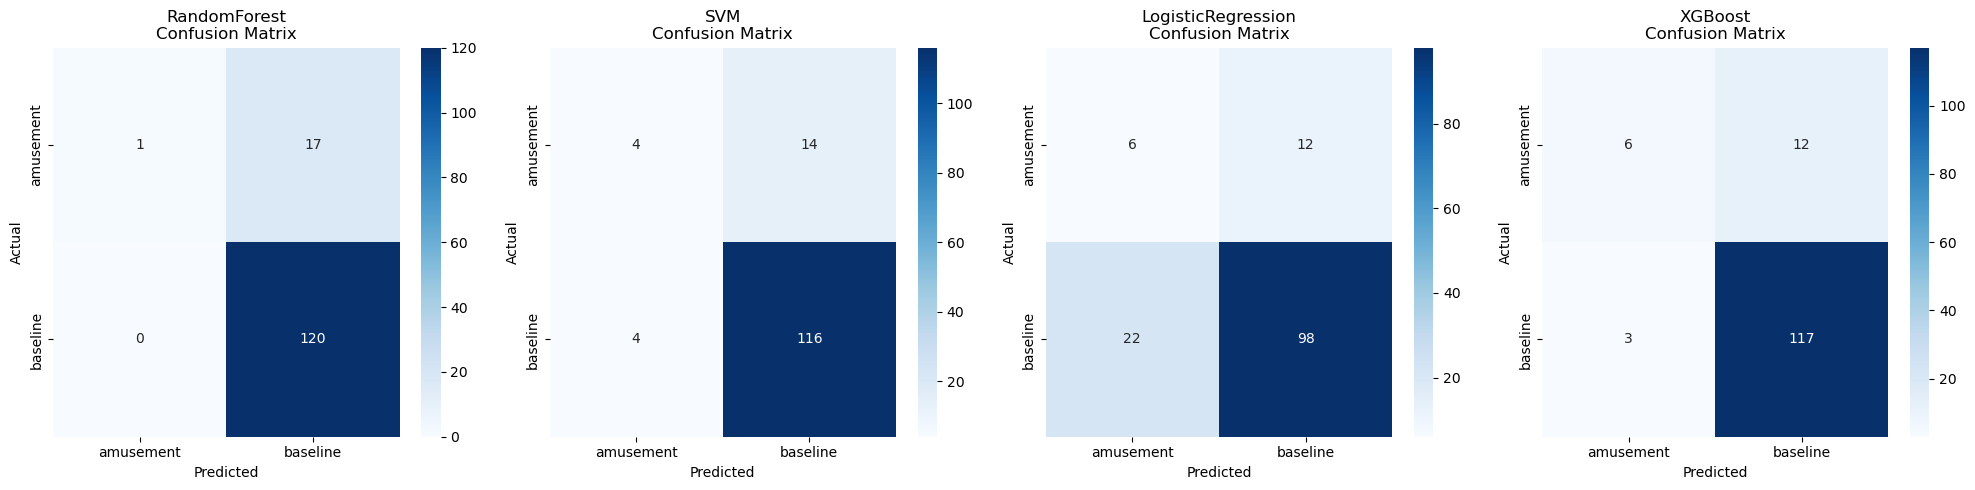


2. FEATURE IMPORTANCE - RANDOM FOREST

📊 TOP 20 NAJWAŻNIEJSZYCH CECH:
--------------------------------------------------------------------------------
        feature  importance
        hr_mean    0.261842
      temp_mean    0.199964
        eda_std    0.194627
chest_temp_mean    0.096477
       eda_mean    0.076445
 chest_eda_mean    0.074716
         hr_std    0.040306
 chest_ecg_mean    0.026556
chest_resp_mean    0.015571
 chest_resp_std    0.013497
       hr_rmssd    0.000000
       hr_range    0.000000
      eda_range    0.000000
      eda_slope    0.000000
      resp_rate    0.000000


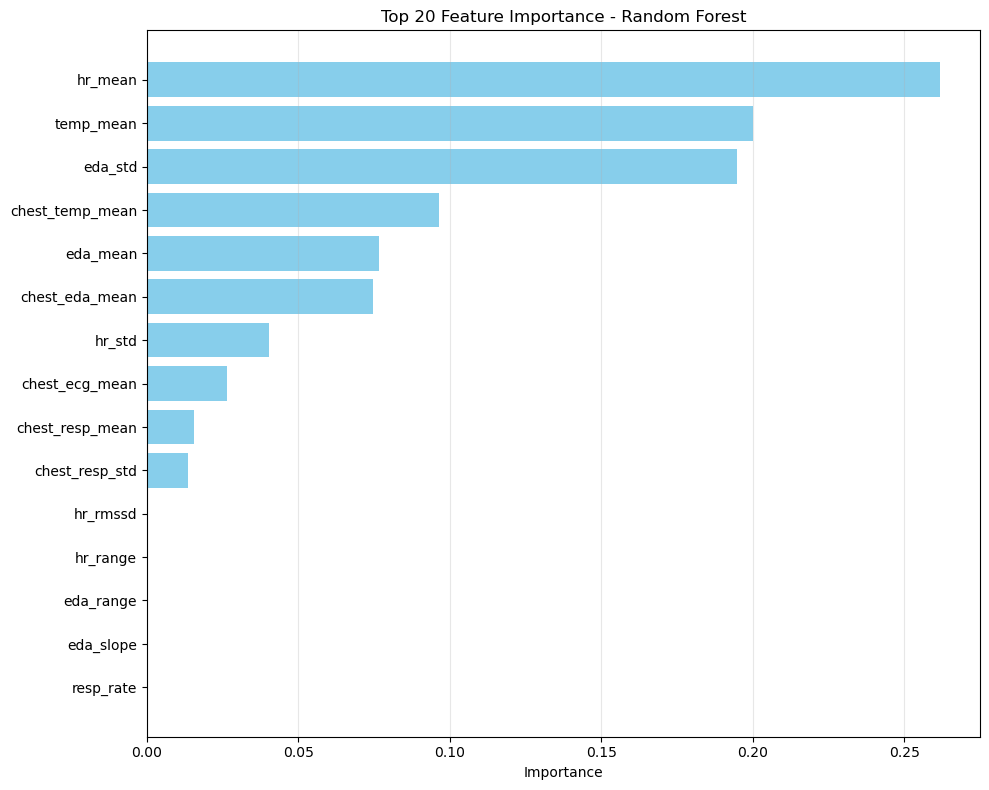


3. ANALIZA: KTÓRE CZUJNIKI SĄ NAJWAŻNIEJSZE?

  Wrist (nadgarstek): 77.3%
  Chest (klatka): 22.7%


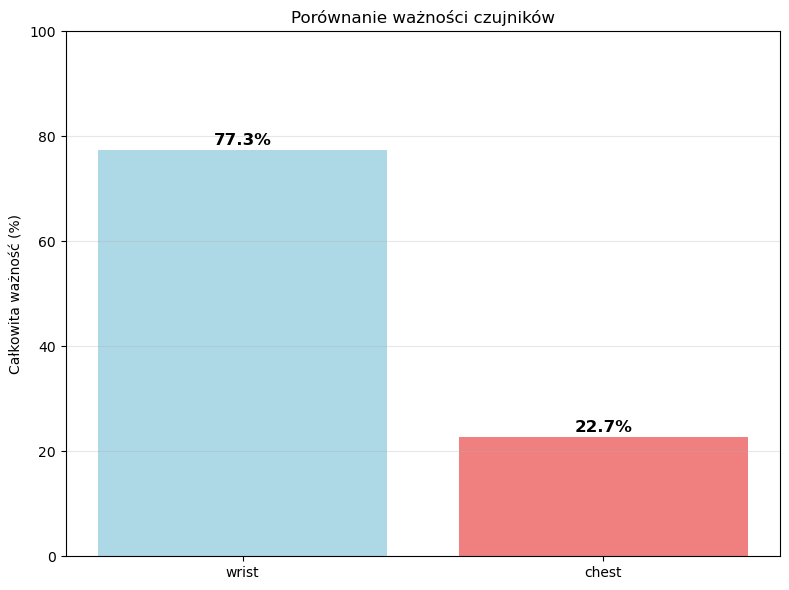


✓ KROK 4 ZAKOŃCZONY - KOMPLETNA ANALIZA GOTOWA!

💡 PODSUMOWANIE:
   ✓ Segmentacja wykonana
   ✓ SMOTE zastosowany (po segmentacji!)
   ✓ Cross-subject validation użyta
   ✓ Modele wytrenowane i porównane
   ✓ Wyniki przeanalizowane


In [28]:
# ============================================================================
# KROK 4: ANALIZA WYNIKÓW - CONFUSION MATRICES I FEATURE IMPORTANCE
# ============================================================================

print("=" * 80)
print("KROK 4: ANALIZA WYNIKÓW")
print("=" * 80)

# Sprawdzenie czy mamy wyniki
if 'all_results' not in globals() or len(all_results) == 0:
    print("\n⚠ Najpierw uruchom KROK 3, aby wytrenować modele")
else:
    # CONFUSION MATRICES
    print(f"\n{'='*80}")
    print("1. CONFUSION MATRICES DLA WSZYSTKICH MODELI")
    print(f"{'='*80}")
    
    from sklearn.metrics import confusion_matrix
    
    n_models = len(all_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(all_results.items()):
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # FEATURE IMPORTANCE (dla RandomForest)
    if 'RandomForest' in all_results:
        print(f"\n{'='*80}")
        print("2. FEATURE IMPORTANCE - RANDOM FOREST")
        print(f"{'='*80}")
        
        # Trenowanie na wszystkich danych dla feature importance
        if SMOTE_AVAILABLE:
            try:
                smote_all = SMOTE(random_state=42, k_neighbors=min(3, len(y_segmented_encoded[y_segmented_encoded == 1]) - 1))
                X_all_bal, y_all_bal = smote_all.fit_resample(X_segmented, y_segmented_encoded)
            except:
                X_all_bal, y_all_bal = X_segmented, y_segmented_encoded
        else:
            X_all_bal, y_all_bal = X_segmented, y_segmented_encoded
        
        # Trenowanie
        rf_all = Pipeline([
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(
                n_estimators=200,
                max_depth=8,
                random_state=42,
                class_weight='balanced'
            ))
        ])
        rf_all.fit(X_all_bal, y_all_bal)
        
        # Feature importance
        feature_importance = rf_all.named_steps['rf'].feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        # Top 20 features
        top_features = importance_df.head(20)
        
        print(f"\n📊 TOP 20 NAJWAŻNIEJSZYCH CECH:")
        print("-" * 80)
        print(top_features.to_string(index=False))
        
        # Wykres
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(top_features)), top_features['importance'].values, color='skyblue')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values)
        ax.invert_yaxis()
        ax.set_xlabel('Importance')
        ax.set_title('Top 20 Feature Importance - Random Forest')
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        # Analiza - które czujniki są najważniejsze?
        print(f"\n{'='*80}")
        print("3. ANALIZA: KTÓRE CZUJNIKI SĄ NAJWAŻNIEJSZE?")
        print(f"{'='*80}")
        
        sensor_importance = {'wrist': 0, 'chest': 0}
        
        for _, row in importance_df.iterrows():
            feature = row['feature']
            importance = row['importance']
            if 'chest' in feature.lower():
                sensor_importance['chest'] += importance
            else:
                sensor_importance['wrist'] += importance
        
        total_importance = sum(sensor_importance.values())
        
        print(f"\n  Wrist (nadgarstek): {sensor_importance['wrist']/total_importance*100:.1f}%")
        print(f"  Chest (klatka): {sensor_importance['chest']/total_importance*100:.1f}%")
        
        # Wykres
        fig, ax = plt.subplots(figsize=(8, 6))
        sensors = list(sensor_importance.keys())
        importances = [sensor_importance[s] / total_importance * 100 for s in sensors]
        
        bars = ax.bar(sensors, importances, color=['lightblue', 'lightcoral'])
        ax.set_ylabel('Całkowita ważność (%)')
        ax.set_title('Porównanie ważności czujników')
        ax.set_ylim([0, 100])
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, imp in zip(bars, importances):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{imp:.1f}%', ha='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n{'='*80}")
    print("✓ KROK 4 ZAKOŃCZONY - KOMPLETNA ANALIZA GOTOWA!")
    print(f"{'='*80}")
    
    print("\n💡 PODSUMOWANIE:")
    print("   ✓ Segmentacja wykonana")
    print("   ✓ SMOTE zastosowany (po segmentacji!)")
    print("   ✓ Cross-subject validation użyta")
    print("   ✓ Modele wytrenowane i porównane")
    print("   ✓ Wyniki przeanalizowane")


## Podsumowanie - Checklist kompletnej analizy

### ✅ Kolejność kroków (WYMAGANA!):

1. **Parsowanie surowych danych** (wykonane w `01_complete_analysis.ipynb` lub przed tym notebookiem)
   - [ ] Wczytanie plików CSV (wrist) z nagłówkami (timestamp, fs)
   - [ ] Wczytanie plików PKL (chest) z encoding='latin1'
   - [ ] Ekstrakcja sygnałów z obu źródeł

2. **Synchronizacja** (wykonane w `01_complete_analysis.ipynb` lub przed tym notebookiem)
   - [ ] Resampling wszystkich sygnałów do **32 Hz**
   - [ ] Wyrównanie czasowe - wspólna oś czasu (timestamp)
   - [ ] Merge wrist i chest na wspólnej osi czasu
   - [ ] Weryfikacja synchronizacji (wszystkie sygnały w tym samym momencie)

3. **Segmentacja** (wykonane w `01_complete_analysis.ipynb` lub przed tym notebookiem)
   - [ ] Podział na okna czasowe (60 sekund)
   - [ ] Feature engineering - statystyki per okno (mean, std, RMSSD, etc.)
   - [ ] Przypisanie label (baseline/stress/amusement) do każdego okna

4. **Analiza niezbalansowania** (KROK 2 w tym notebooku)
   - [ ] Sprawdzenie rozkładu klas
   - [ ] Identyfikacja problemu (baseline 120, amusement 18, stress 4)

5. **SMOTE** (KROK 3 w tym notebooku)
   - [ ] ✅ **PO SEGMENTACJI** (nie na surowych sygnałach!)
   - [ ] Tylko na zbiorze treningowym (nie na test!)
   - [ ] Oversampling klasy mniejszościowej

6. **Cross-subject validation** (KROK 3 w tym notebooku)
   - [ ] GroupKFold - grupowanie po uczestniku
   - [ ] Każdy fold = jeden uczestnik w test

7. **Trenowanie modeli** (KROK 3 w tym notebooku)
   - [ ] RandomForest z class_weight='balanced'
   - [ ] SVM z class_weight='balanced'
   - [ ] XGBoost z odpowiednimi wagami
   - [ ] Użycie Macro F1-score (nie accuracy!)

8. **Analiza wyników** (KROK 4 w tym notebooku)
   - [ ] Confusion matrices
   - [ ] Feature importance
   - [ ] Analiza ważności czujników (wrist vs chest)

### ⚠️ Najczęstsze błędy:

1. ❌ SMOTE przed segmentacją - **BŁĄD!**
2. ❌ Losowy podział train/test zamiast cross-subject - **BŁĄD!**
3. ❌ Użycie tylko accuracy zamiast Macro F1 - **BŁĄD!**
4. ❌ Brak synchronizacji wrist i chest - **BŁĄD!**

### ✅ Prawidłowa kolejność:

**Parsowanie → Synchronizacja → Segmentacja → SMOTE → ML → Analiza**
